# モデルを分けて作る

---

## 本資料の概要

### 目的

線形回帰モデルのような単純なモデルを用いる場合、モデルを場合分けすることで精度を改善できることがある。  
本資料では、線形回帰モデルを例に、モデルを場合分けすることで精度を改善できる理由を説明する。

### 設定

線形回帰モデルを用いてスタジアムの収容人数から観客数を予測することを考える。  
開催大会 (J1/J2) によって試合の注目度が異なることから、開催大会によって収容人数と観客数の関係も異なっていることが予想される。  
そこで、開催大会別にモデルを分けた場合と分けなかった場合を比較し、モデルを分けることで精度がどう変化するか確認する。

* 目的変数
    * 観客数 `y`
* 説明変数
    * スタジアムの収容人数 `capa`
* モデルの場合分け条件
    * 開催大会 `stage` (J1/J2)
* モデル
    * 線形回帰モデル

---

## セットアップ

### モジュールの読み込み

In [1]:
# 多次元配列やデータフレームの操作
import numpy as np
import pandas as pd

# 線形回帰モデル
from sklearn.linear_model import LinearRegression

# 決定木
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# グラフの描画
from matplotlib import pyplot as plt
import seaborn as sns

### パスの設定

In [2]:
# データの場所
input_path = '../input_data/jleague/'

# 提出ファイルを出力する場所
submit_path = '../submit/'

### データの読み込み

In [3]:
# 試合データ
train = pd.read_csv(input_path + 'train.csv')
test = pd.read_csv(input_path + 'test.csv')

# スタジアムデータ
stadium = pd.read_csv(input_path + 'stadium.csv')

---

## データ加工

### 試合データにスタジアムデータを結合

In [4]:
train = pd.merge(train, stadium, how='inner', left_on='stadium', right_on='name')
test = pd.merge(test, stadium, how='inner', left_on='stadium', right_on='name')

In [5]:
train.head()

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,name,address,capa
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
1,14012,11831,2012,Ｊ１,第３節第１日,03/24(土),13:03,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
2,14031,13147,2012,Ｊ１,第５節第１日,04/07(土),14:03,ベガルタ仙台,ジュビロ磐田,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ仙台／ＮＨＫ静岡,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
3,14055,17192,2012,Ｊ１,第７節第１日,04/21(土),19:04,ベガルタ仙台,ＦＣ東京,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ ＢＳ１,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
4,14075,18525,2012,Ｊ１,第１０節第１日,05/06(日),13:04,ベガルタ仙台,清水エスパルス,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ仙台,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694


### 必要な列を抽出

In [6]:
train = train[['id', 'y', 'stage', 'capa']].copy()
test = test[['id', 'stage', 'capa']].copy()

In [7]:
train.head()

,id,y,stage,capa
0,13994,18250,Ｊ１,19694
1,14012,11831,Ｊ１,19694
2,14031,13147,Ｊ１,19694
3,14055,17192,Ｊ１,19694
4,14075,18525,Ｊ１,19694


### `stage` を英数字に置換

環境によっては、データに日本語文字列が含まれているとグラフが文字化けする。  
文字化け対策として、日本語文字列を英数字文字列に置換しておく。

In [8]:
train.loc[train['stage'] == 'Ｊ１', 'stage'] = 'J1'
train.loc[train['stage'] == 'Ｊ２', 'stage'] = 'J2'
test.loc[test['stage'] == 'Ｊ１', 'stage'] = 'J1'
test.loc[test['stage'] == 'Ｊ２', 'stage'] = 'J2'

In [9]:
train.head()

,id,y,stage,capa
0,13994,18250,J1,19694
1,14012,11831,J1,19694
2,14031,13147,J1,19694
3,14055,17192,J1,19694
4,14075,18525,J1,19694


### `capa` と `y` の関係の確認

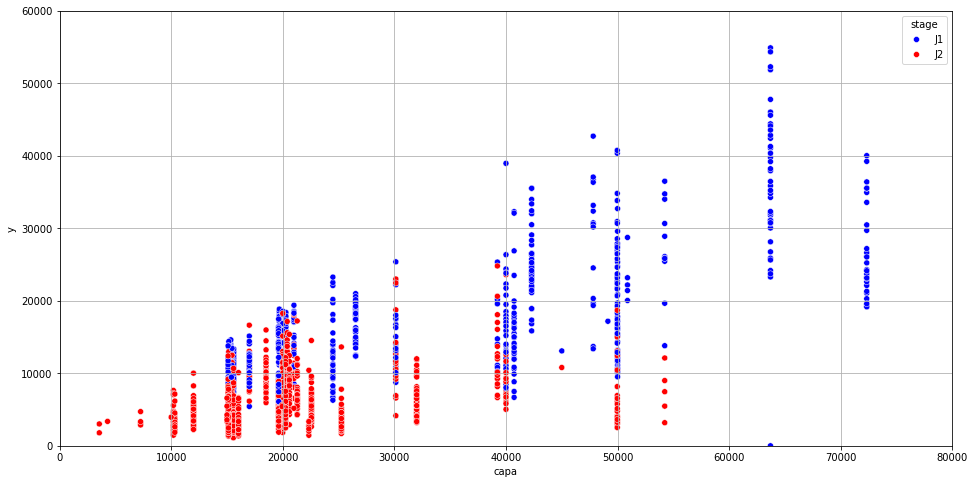

In [10]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data=train, x='capa', y='y', hue='stage', palette=['blue', 'red'])
plt.xlim(0, 80000)
plt.ylim(0, 60000)
plt.grid()
plt.show()

`capa` が大きいほど `y` も大きい傾向にあることがわかる。  
`stage` 別にみると、`capa` の増加に対して `y` の増加がJ2は緩やかなのに対し、J1は急であることがわかる。

---

## モデル1 データ全体で一つのモデルを作る

モデルを分けずにデータ全体を使って一つのモデルを作成し、モデルの当てはまり具合を確認する。

### 学習

In [11]:
reg_all = LinearRegression()
reg_all = reg_all.fit(train[['capa']], train['y'])

### 予測結果の確認

/Users/ryotaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


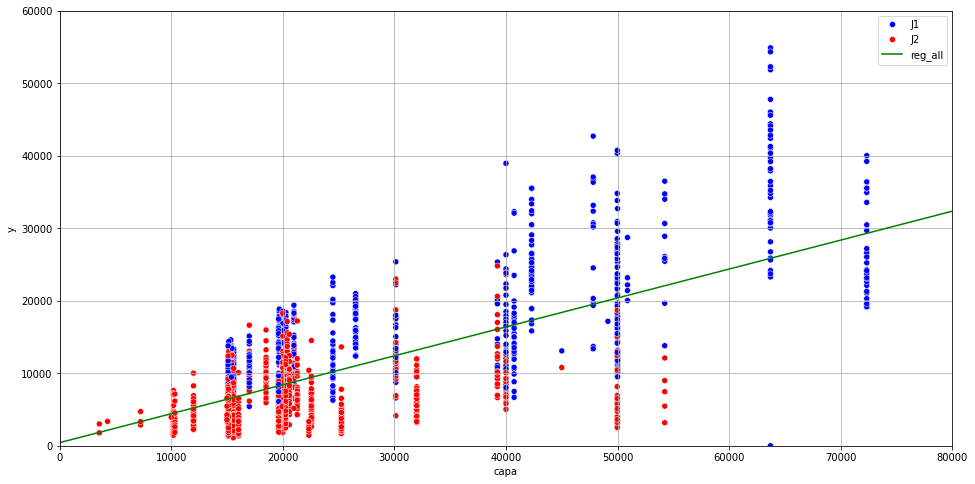

In [12]:
reg_all_x = np.array([[0], [80000]])
reg_all_y = reg_all.predict(reg_all_x)

plt.figure(figsize=(16, 8))
sns.scatterplot(data=train, x='capa', y='y', hue='stage', palette=['blue', 'red'])
sns.lineplot(x=reg_all_x[:, 0], y=reg_all_y, color='green', label='reg_all')
plt.xlim(0, 80000)
plt.ylim(0, 60000)
plt.grid()
plt.show()

`capa` が大きくなると `y` も大きくなるという全体的な傾向は捉えられている。  
一方、`stage` 別にみると実測値と予測値の間に偏りがあるように見える。  
そこで、次に残差プロット (ここでは、横軸に説明変数、縦軸に残差をプロットしたもの) を描画してみる。

### 残差の確認

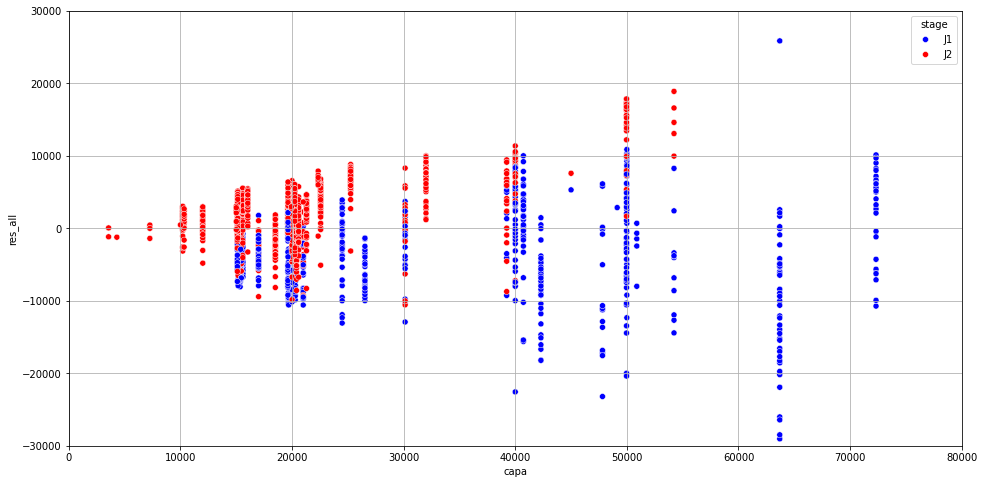

In [13]:
train['y_pred_all'] = reg_all.predict(train[['capa']])
train['res_all'] = train['y_pred_all'] - train['y']

plt.figure(figsize=(16, 8))
sns.scatterplot(data=train, x='capa', y='res_all', hue='stage', palette=['blue', 'red'])
plt.xlim(0, 80000)
plt.ylim(-30000, 30000)
plt.grid()
plt.show()

このグラフから、`stage` ごとに残差に偏りがある (予測の外し方に傾向がある) ことが確認できる。

* J1では、30,000人以下や60,000人以上の試合において少なめに予測する (`res` が負の値になる) 傾向にある。
* J2では、30,000人以上の試合において多めに予測する (`res` が正の値になる) 傾向にある。

このように、ある条件の下で予測の外し方に傾向が見られるのであれば、  その条件別にモデルを分けて作ることでモデルの当てはまりを改善できる。

---

## モデル2 J1とJ2でモデルを分けて作る

`stage` 別にモデルを分けて作成し、モデルの当てはまり具合を確認する。

### 学習

In [14]:
reg_j1 = LinearRegression()
reg_j1 = reg_j1.fit(train.loc[train['stage'] == 'J1', ['capa']], train.loc[train['stage'] == 'J1', 'y'])
reg_j2 = LinearRegression()
reg_j2 = reg_j2.fit(train.loc[train['stage'] == 'J2', ['capa']], train.loc[train['stage'] == 'J2', 'y'])

### 予測結果の確認

/Users/ryotaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ryotaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


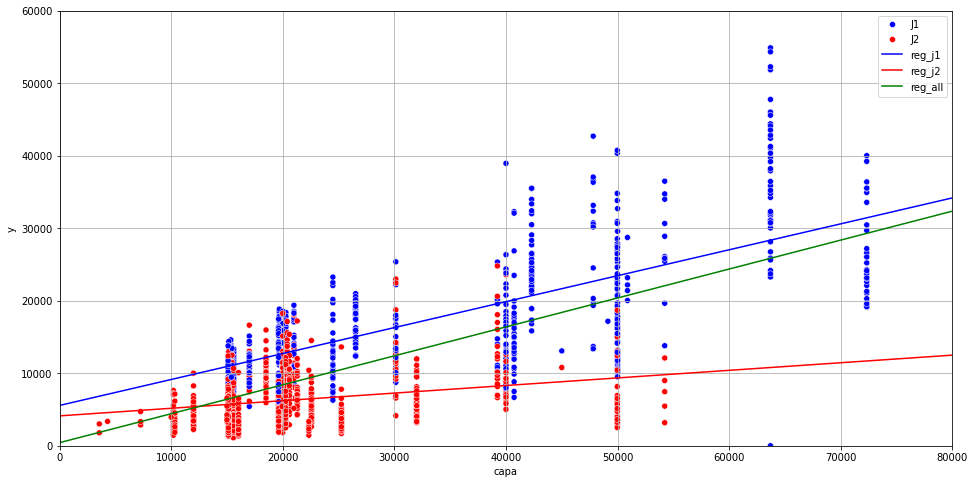

In [15]:
reg_j1_x = np.array([[0], [80000]])
reg_j1_y = reg_j1.predict(reg_j1_x)
reg_j2_x = np.array([[0], [80000]])
reg_j2_y = reg_j2.predict(reg_j2_x)

plt.figure(figsize=(16, 8))
sns.scatterplot(data=train, x='capa', y='y', hue='stage', palette=['blue', 'red'])
sns.lineplot(x=reg_j1_x[:, 0], y=reg_j1_y, color='blue', label='reg_j1')
sns.lineplot(x=reg_j2_x[:, 0], y=reg_j2_y, color='red', label='reg_j2')
sns.lineplot(x=reg_all_x[:, 0], y=reg_all_y, color='green', label='reg_all')
plt.xlim(0, 80000)
plt.ylim(0, 60000)
plt.grid()
plt.show()

モデルを分けなかった場合 (緑) と比較すると、J1 (青) は全体的に観客数を多めに予測するようモデルが修正されていることがわかる。  
一方で、J2 (赤) は傾きが小さくなり、収容人数が大きくなっても観客数はあまり大きくならないようモデルが修正されている。

### 残差の確認

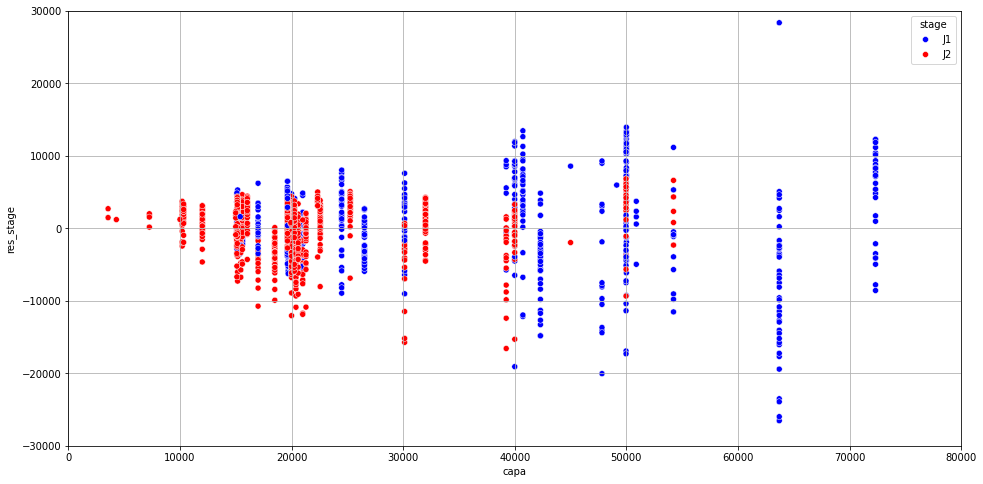

In [16]:
train['y_pred_stage'] = 0.0
train.loc[train['stage'] == 'J1', 'y_pred_stage'] = reg_j1.predict(train.loc[train['stage'] == 'J1', ['capa']])
train.loc[train['stage'] == 'J2', 'y_pred_stage'] = reg_j2.predict(train.loc[train['stage'] == 'J2', ['capa']])
train['res_stage'] = train['y_pred_stage'] - train['y']

plt.figure(figsize=(16, 8))
sns.scatterplot(data=train, x='capa', y='res_stage', hue='stage', palette=['blue', 'red'])
plt.xlim(0, 80000)
plt.ylim(-30000, 30000)
plt.grid()
plt.show()

モデルを分けずに作ったときに生じていた、`stage` ごとの予測の外し方の傾向が解消されていることが確認できる。

---

## 投稿結果の比較

テストデータに対して予測を行い、モデルを分けて作ることで予測精度がどう変化するか確認する。  
モデルを分けることで精度が改善していることが確認できる。

### モデル1

In [17]:
test['y_pred_all'] = reg_all.predict(test[['capa']])
test[['id', 'y_pred_all']].to_csv(submit_path + 'submit_reg_all.csv', index=False, header=False)

投稿スコア: 6,074.2796921

### モデル2

In [18]:
test['y_pred_stage'] = 0.0
test.loc[test['stage'] == 'J1', 'y_pred_stage'] = reg_j1.predict(test.loc[test['stage'] == 'J1', ['capa']])
test.loc[test['stage'] == 'J2', 'y_pred_stage'] = reg_j2.predict(test.loc[test['stage'] == 'J2', ['capa']])
test[['id', 'y_pred_stage']].to_csv(submit_path + 'submit_reg_stage.csv', index=False, header=False)

投稿スコア: 4,800.0480407

---

## 補足1 ダミー変数ではダメなのか？

モデルを分ける方法以外にも、`stage` をダミー変数化して説明変数に追加する方法が考えられる。  
しかし、ダミー変数化して説明変数に追加する方法は、モデルを分ける方法よりも精度面で劣る場合がある。

### ダミー変数化

In [19]:
train['j1'] = 0
train.loc[train['stage'] == 'J1', 'j1'] = 1

### 学習

In [20]:
reg_dummy = LinearRegression()
reg_dummy = reg_dummy.fit(train[['capa', 'j1']], train['y'])

### 予測結果の確認

/Users/ryotaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ryotaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


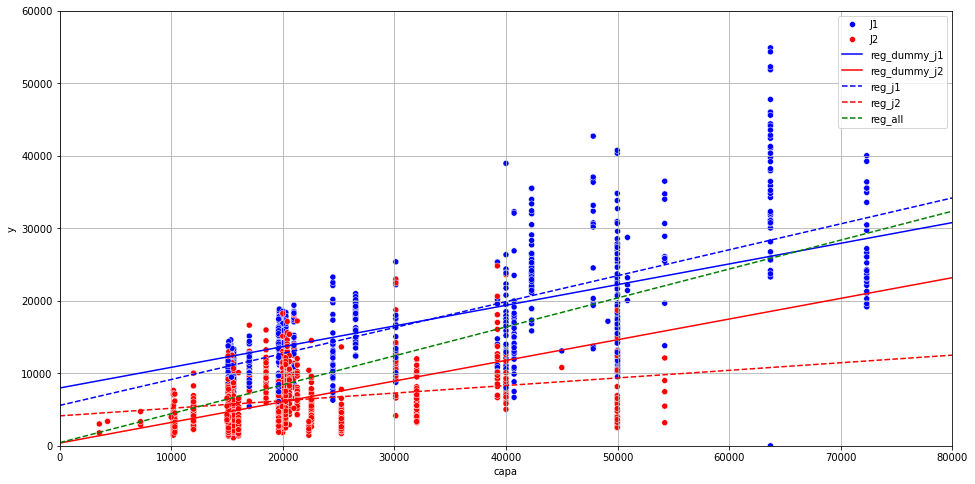

In [21]:
reg_dummy_j1_x = np.array([[0, 1], [80000, 1]])
reg_dummy_j1_y = reg_dummy.predict(reg_dummy_j1_x)
reg_dummy_j2_x = np.array([[0, 0], [80000, 0]])
reg_dummy_j2_y = reg_dummy.predict(reg_dummy_j2_x)

plt.figure(figsize=(16, 8))
sns.scatterplot(data=train, x='capa', y='y', hue='stage', palette=['blue', 'red'])
sns.lineplot(x=reg_dummy_j1_x[:, 0], y=reg_dummy_j1_y, color='blue', label='reg_dummy_j1')
sns.lineplot(x=reg_dummy_j2_x[:, 0], y=reg_dummy_j2_y, color='red', label='reg_dummy_j2')
sns.lineplot(x=reg_j1_x[:, 0], y=reg_j1_y, linestyle='--', color='blue', label='reg_j1')
sns.lineplot(x=reg_j2_x[:, 0], y=reg_j2_y, linestyle='--', color='red', label='reg_j2')
sns.lineplot(x=reg_all_x[:, 0], y=reg_all_y, linestyle='--', color='green', label='reg_all')
plt.xlim(0, 80000)
plt.ylim(0, 60000)
plt.grid()
plt.show()

モデルを分けなかった場合 (緑) と比較すると、J2の30,000人以上の試合において多めに予測する傾向がまだ強く残っている。  
これは、ダミー変数は条件別に直線の切片を変えることはできるものの、条件別に直線の傾きを変えることはできないためである。  
傾きと切片の両方を条件別に変える必要がある場合には、モデルを分けて作るなど別の方法を取る必要がある。

---

## 補足2 非線形なモデルを分ける意味はあるのか？

非線形なモデルを用いる場合、モデルを分けて作っても予測精度が改善しない場合がある。  
これは、非線形なモデルは表現力が高く、手作業で場合分けしなくても当てはまりのよいモデルが得られるためである。  
モデルを分けると学習に使えるデータ数が減ってしまうため、むしろ過学習が起こりむしろ予測精度が悪化してしまう可能性もある。

### 学習

In [22]:
tree = DecisionTreeRegressor(min_samples_leaf=200, random_state=0)
tree = tree.fit(train[['capa', 'j1']], train['y'])

### 得られたモデルの確認

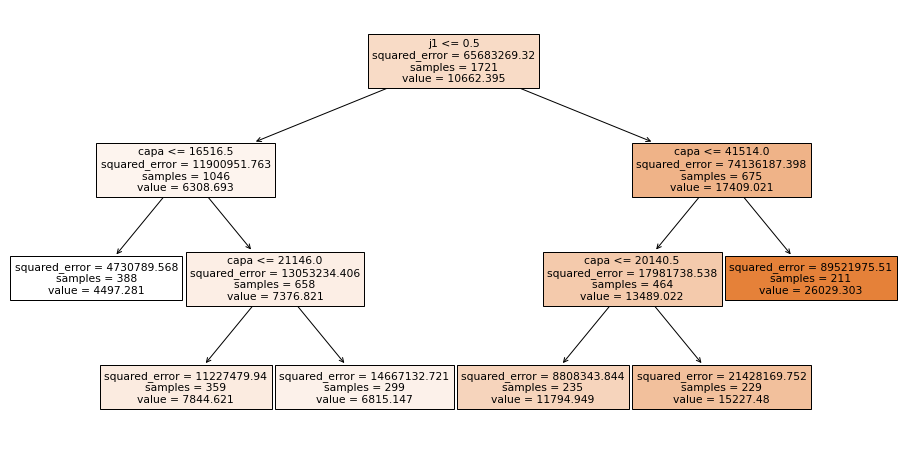

In [23]:
plt.figure(figsize=(16, 8))
plot_tree(tree, feature_names=['capa', 'j1'], filled=True)
plt.show()

手作業で `stage` で場合分けしなくても、`j1` で分岐したモデルが作られていることがわかる。

### 予測結果の確認

/Users/ryotaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/ryotaro/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


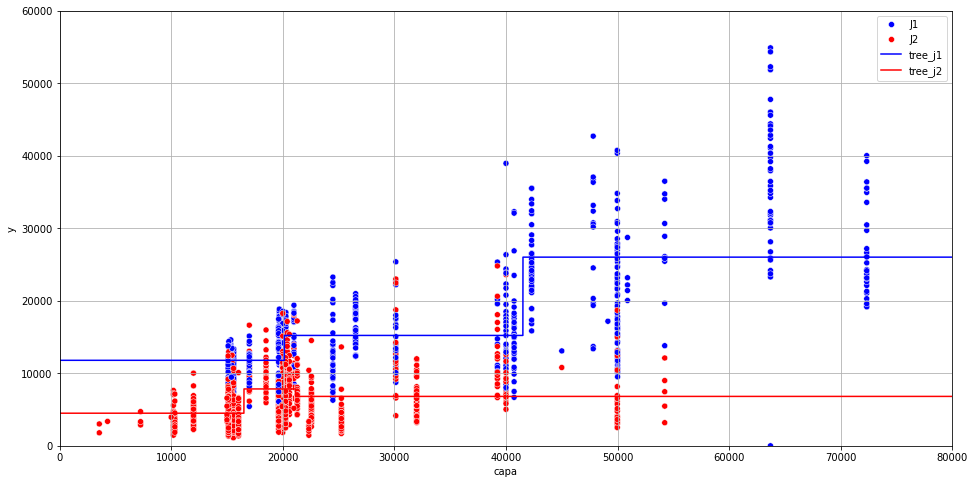

In [24]:
tree_j1_x = np.array([[i, 1] for i in range(80000)])
tree_j1_y = tree.predict(tree_j1_x)
tree_j2_x = np.array([[i, 0] for i in range(80000)])
tree_j2_y = tree.predict(tree_j2_x)

plt.figure(figsize=(16, 8))
sns.scatterplot(data=train, x='capa', y='y', hue='stage', palette=['blue', 'red'])
sns.lineplot(x=tree_j1_x[:, 0], y=tree_j1_y, color='blue', label='tree_j1')
sns.lineplot(x=tree_j2_x[:, 0], y=tree_j2_y, color='red', label='tree_j2')
plt.xlim(0, 80000)
plt.ylim(0, 60000)
plt.grid()
plt.show()

ダミー変数を追加すること `stage` 別に当てはまりのよい曲線が得られている。